In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models,layers

2023-02-06 21:13:58.472517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 21:13:58.642842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-06 21:13:58.642863: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-06 21:13:59.298933: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
image_size = 256
batch_size = 32
channels = 3
epochs = 50


In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('datasetFd',
                                                              shuffle=True,
                                                              image_size=(image_size,image_size),
                                                              batch_size=batch_size)

Found 1835 files belonging to 6 classes.


2023-02-06 21:16:17.975229: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-06 21:16:17.975250: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-06 21:16:17.975272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: GiBiO
2023-02-06 21:16:17.975278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: GiBiO
2023-02-06 21:16:17.975375: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-02-06 21:16:17.975413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.86.1
2023-02-06 21:16:17.97

In [4]:
class_names = dataset.class_names
class_names

['Byen', 'Foli', 'Koi', 'Sing', 'Sol', 'Sorputi']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 2 0 1 2 2 0 2 5 0 2 5 0 1 1 0 0 3 2 2 2 1 1 0 1 0 1 2 0 2 3 5]


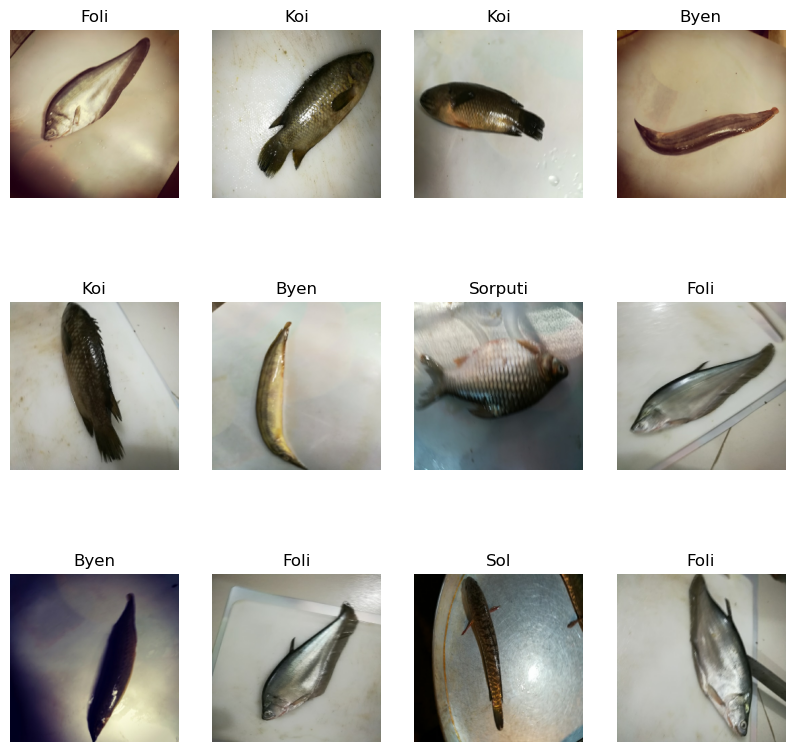

In [7]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    # print(image_batch[0].numpy())
    ax = plt.subplot(3,4,i+1)
    plt.title(class_names[label_batch[i]])
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis('off')

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_rescaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:

input_shape = (batch_size, image_size, image_size, channels)
n_classes = 8
model = models.Sequential([
    resize_rescaling,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    


])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [15]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size = batch_size,
    verbose=1,
    validation_data = val_ds

)

Epoch 1/50


2023-02-06 21:20:13.206689: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 264257536 exceeds 10% of free system memory.
2023-02-06 21:20:13.810066: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 66064384 exceeds 10% of free system memory.
2023-02-06 21:20:13.998204: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 128000000 exceeds 10% of free system memory.
2023-02-06 21:20:14.222367: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 31490048 exceeds 10% of free system memory.
2023-02-06 21:20:14.256927: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 29491200 exceeds 10% of free system memory.


46/46 [==============================] - 140s 3s/step - loss: 1.7485 - accuracy: 0.2488 - val_loss: 1.7461 - val_accuracy: 0.2438
Epoch 2/50
46/46 [==============================] - 148s 3s/step - loss: 1.5766 - accuracy: 0.3570 - val_loss: 1.5332 - val_accuracy: 0.3187
Epoch 3/50
46/46 [==============================] - 131s 3s/step - loss: 1.2752 - accuracy: 0.4879 - val_loss: 1.1618 - val_accuracy: 0.5437
Epoch 4/50
46/46 [==============================] - 134s 3s/step - loss: 1.1877 - accuracy: 0.4990 - val_loss: 1.0453 - val_accuracy: 0.5813
Epoch 5/50
46/46 [==============================] - 133s 3s/step - loss: 0.9414 - accuracy: 0.6334 - val_loss: 1.1539 - val_accuracy: 0.5875
Epoch 6/50
46/46 [==============================] - 133s 3s/step - loss: 0.8513 - accuracy: 0.6885 - val_loss: 0.8964 - val_accuracy: 0.6250
Epoch 7/50
46/46 [==============================] - 137s 3s/step - loss: 0.6922 - accuracy: 0.7560 - val_loss: 0.9309 - val_accuracy: 0.6562
Epoch 8/50
46/46 [======

In [19]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 4s 496ms/step - loss: 0.4494 - accuracy: 0.8973
